# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [6]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count, udf, max, hour,desc
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Window
# from pyspark.sql.DataFrame import createOrReplaceTempView
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [7]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
## Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [9]:
df.persist

<bound method DataFrame.persist of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]>

In [10]:
#checking if there is any null values in the sessionId column
df.where(df.sessionId == np.nan).count()

0

In [11]:
#checking if there is any null values in the userId column
df.where(df.userId == np.nan).count()

0

In [12]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# Building a function to be used to create churn column
churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0,  IntegerType())

In [14]:
# Creating churn column
df = df.withColumn("churn", churn(df.page))
churn_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churnInfo", max("churn").over(churn_window))
df.select(["userId","churnInfo"]).show()

+------+---------+
|userId|churnInfo|
+------+---------+
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
|100010|        0|
+------+---------+
only showing top 20 rows



In [99]:
df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [15]:
class_counts_pd = df.groupBy('page').count().sort(desc('count')).toPandas()

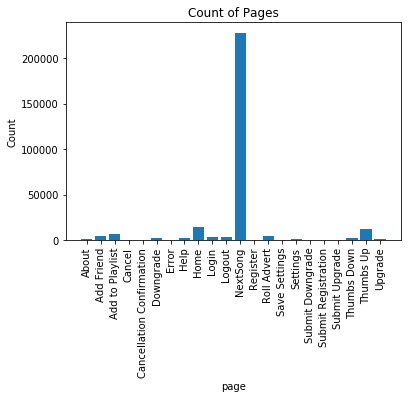

In [16]:
plt.bar(class_counts_pd['page'], class_counts_pd['count'])
plt.xlabel('page')
plt.ylabel('Count')
plt.title('Count of Pages')
plt.xticks(rotation=90)
plt.show()

In [89]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour, IntegerType())

In [90]:
df = df.withColumn("hour", get_hour(df.ts))

In [19]:
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [20]:
songs_in_hour.show(24)
songs_in_hour = songs_in_hour.toPandas()
songs_in_hour = songs_in_hour.astype({"hour": int})
songs_in_hour = songs_in_hour.sort_values(by='hour').reset_index(drop=True)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
|  20|10856|
|  21|10458|
|  22|10122|
|  23| 9630|
+----+-----+



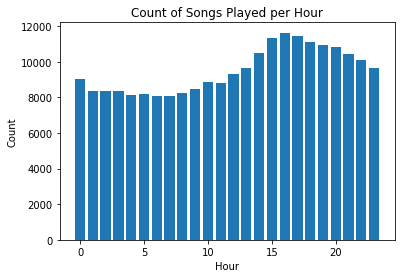

In [21]:
plt.bar(songs_in_hour['hour'], songs_in_hour['count'])
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Count of Songs Played per Hour')
plt.show()

In [22]:
#checking the most top 10 listened artists
df.filter(col("artist").isNotNull()).groupBy("artist").count().sort(desc("count")).show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
+--------------------+-----+
only showing top 10 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [51]:
# Counting the number of actions for each user
number_of_actions = df.groupBy("userId").pivot("page").count().fillna(0)

In [61]:
number_of_actions.show(10)

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+-----+------+--------+--------+-----------+-------------+--------+----------------+-------------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Login|Logout|NextSong|Register|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Registration|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+-----+------+--------+--------+-----------+-------------+--------+----------------+-------------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|     0|                        0|        5|    0|   2|  20|    0|     5|     387|       0|          7|            0|       3|               0|                  0|             1|          6|       21|      2|
|100

In [84]:
# Creating Gender Feature 
IsMale = udf(lambda x: 1 if x == "M" else 0, IntegerType())
genderIndexMod = df.withColumn("genderIndex", IsMale(df.gender)).dropDuplicates(['userId'])
genderIndexMod = genderIndexMod.select("userId", "genderIndex")

fullFeatures = genderIndexMod.join(number_of_actions, on = "userId", how="outer")

In [94]:
# Creating Average Hour for each user
avgHour = df.groupBy("userId").avg("hour").withColumnRenamed("avg(hour)", "avgHour")

fullFeatures = fullFeatures.join(avgHour, on = "userId", how="outer")

In [106]:
# Creating the level Feature
get_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
level = df.withColumn("levelIndex", get_level(df.level)).select("userId", "levelIndex").dropDuplicates(['userId'])

fullFeatures = fullFeatures.join(level, on = "userId", how="outer")

In [113]:
# Creating Churn Feature
churn = df.groupBy("userId").agg(max("churn")).dropDuplicates(["userId"])

fullFeatures = fullFeatures.join(churn, on = "userId", how="outer")

In [114]:
fullFeatures.count()

226

In [115]:
len(fullFeatures.columns)

28

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.